In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

In [113]:
df = pd.read_csv('shopping_behavior_updated.csv')
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [128]:
print("Step 1: Basic feature preparation...")
frequency_mapping = {
    "Weekly": 52,
    "Fortnightly": 26,
    "Bi-Weekly": 24,
    "Monthly": 12,
    "Every 3 Months": 4,
    "Quarterly": 4,
    "Annually": 1
}
df["Purchase_Frequency"] = df["Frequency of Purchases"].map(frequency_mapping)

Step 1: Basic feature preparation...


In [129]:
df['customer_profile'] = df.apply(
    lambda row: f"A {row['Gender']} customer, age {row['Age']}, purchased {row['Item Purchased']} " +
    f"from {row['Category']} category, {row['Color']} color, in {row['Season']}, size {row['Size']}. " +
    f"Previous purchases: {row['Previous Purchases']}. " +
    f"Purchase frequency: {row['Frequency of Purchases']}. " +
    f"They spent ${row['Purchase Amount (USD)']}. " +
    f"Rating: {row['Review Rating']}/5. " +
    f"Discount applied: {row['Discount Applied']}. " +
    f"Promo code used: {row['Promo Code Used']}. " +
    f"Subscription status: {row['Subscription Status']}. " +
    f"Shipping type: {row['Shipping Type']}. " +
    f"Payment method: {row['Payment Method']}.",
    axis=1
)

In [130]:
# Use a language model to create embeddings
print("Creating embeddings with language model...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight model, you can use larger ones for better results
embeddings = model.encode(df['customer_profile'].tolist(), show_progress_bar=True)


Creating embeddings with language model...


Batches:   0%|          | 0/122 [00:00<?, ?it/s]

In [131]:
import umap.umap_ as umap

# Use UMAP to reduce dimensionality for visualization and clustering
print("Reducing dimensionality...")
reducer = umap.UMAP(n_components=10, metric='cosine', random_state=42)
umap_embeddings = reducer.fit_transform(embeddings)

Reducing dimensionality...


Finding optimal number of clusters...


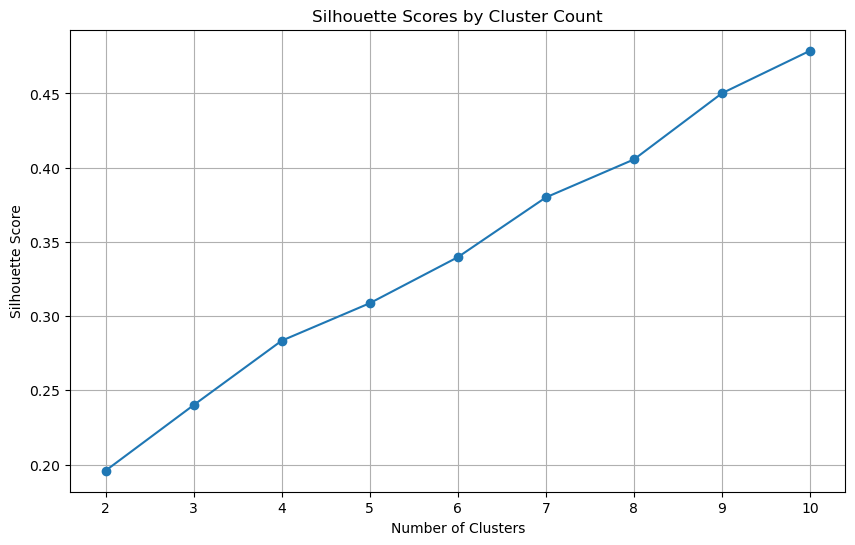

In [132]:
# Determine optimal number of clusters
print("Finding optimal number of clusters...")
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(umap_embeddings)
    silhouette_scores.append(silhouette_score(umap_embeddings, cluster_labels))

# Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores by Cluster Count')
plt.grid(True)
plt.savefig('llm_silhouette_scores.png')


In [133]:
# Best K based on silhouette score
best_k = np.argmax(silhouette_scores) + 2
print(f"Optimal number of clusters: {best_k} (Silhouette Score: {silhouette_scores[best_k-2]:.4f})")

# K-means with optimal K
print(f"Clustering with K={best_k}...")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(umap_embeddings)


Optimal number of clusters: 10 (Silhouette Score: 0.4788)
Clustering with K=10...


In [134]:
# 2D UMAP projection for visualization
viz_reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
viz_embedding = viz_reducer.fit_transform(embeddings)
df['UMAP1'] = viz_embedding[:, 0]
df['UMAP2'] = viz_embedding[:, 1]

# Profile the clusters
segment_stats = df.groupby('Cluster').agg({
    'Customer ID': 'count',
    'Purchase Amount (USD)': 'mean',
    'Age': 'mean',
    'Previous Purchases': 'mean',
    'Review Rating': 'mean'
}).round(2)

segment_stats['Percentage'] = (segment_stats['Customer ID'] / len(df) * 100).round(1)
segment_stats = segment_stats.rename(columns={'Customer ID': 'Count'})

print("\nSegment Statistics:")
print(segment_stats)


Segment Statistics:
         Count  Purchase Amount (USD)    Age  Previous Purchases  \
Cluster                                                            
0          288                  59.16  43.61               24.55   
1          758                  59.82  44.52               25.17   
2          324                  57.17  44.31               24.96   
3          314                  59.60  43.38               25.03   
4          485                  61.22  44.52               26.31   
5          415                  60.66  43.59               24.29   
6          339                  59.27  44.33               26.53   
7          140                  60.55  43.07               26.44   
8          684                  60.19  43.57               25.53   
9          153                  57.89  46.05               24.71   

         Review Rating  Percentage  
Cluster                             
0                 3.75         7.4  
1                 3.78        19.4  
2             

In [135]:
# Automatically generate segment names using profile features
segment_names = {}
for cluster in range(best_k):
    cluster_df = df[df['Cluster'] == cluster]
    
    # Calculate key metrics
    avg_spending = cluster_df['Purchase Amount (USD)'].mean()
    avg_previous = cluster_df['Previous Purchases'].mean()
    avg_rating = cluster_df['Review Rating'].mean()
    discount_rate = (cluster_df['Discount Applied'] == 'Yes').mean()
    subscription_rate = (cluster_df['Subscription Status'] == 'Yes').mean()
    
    # Top categories, colors, and seasons
    top_category = cluster_df['Category'].value_counts().index[0]
    top_season = cluster_df['Season'].value_counts().index[0]
    top_items = cluster_df['Item Purchased'].value_counts().nlargest(2).index.tolist()
    
    # Determine spending level
    if avg_spending > df['Purchase Amount (USD)'].quantile(0.75):
        spending = "High-Spending"
    elif avg_spending < df['Purchase Amount (USD)'].quantile(0.25):
        spending = "Budget-Conscious"
    else:
        spending = "Mid-Range"
    
    # Determine loyalty level
    if avg_previous > df['Previous Purchases'].quantile(0.75):
        loyalty = "Loyal"
    elif avg_previous < df['Previous Purchases'].quantile(0.25):
        loyalty = "New"
    else:
        loyalty = "Returning"
    
    # Create segment name
    if subscription_rate > 0.5:
        prefix = "Subscribed"
    elif discount_rate > 0.7:
        prefix = "Discount-Seeking"
    else:
        prefix = ""
    
    if prefix:
        name = f"{prefix} {loyalty} {spending} Shoppers"
    else:
        name = f"{loyalty} {spending} Shoppers"
    
    # Add specialty if very focused on one category
    if cluster_df['Category'].value_counts(normalize=True).iloc[0] > 0.6:
        name += f" ({top_category} Focus)"
    
    segment_names[cluster] = name


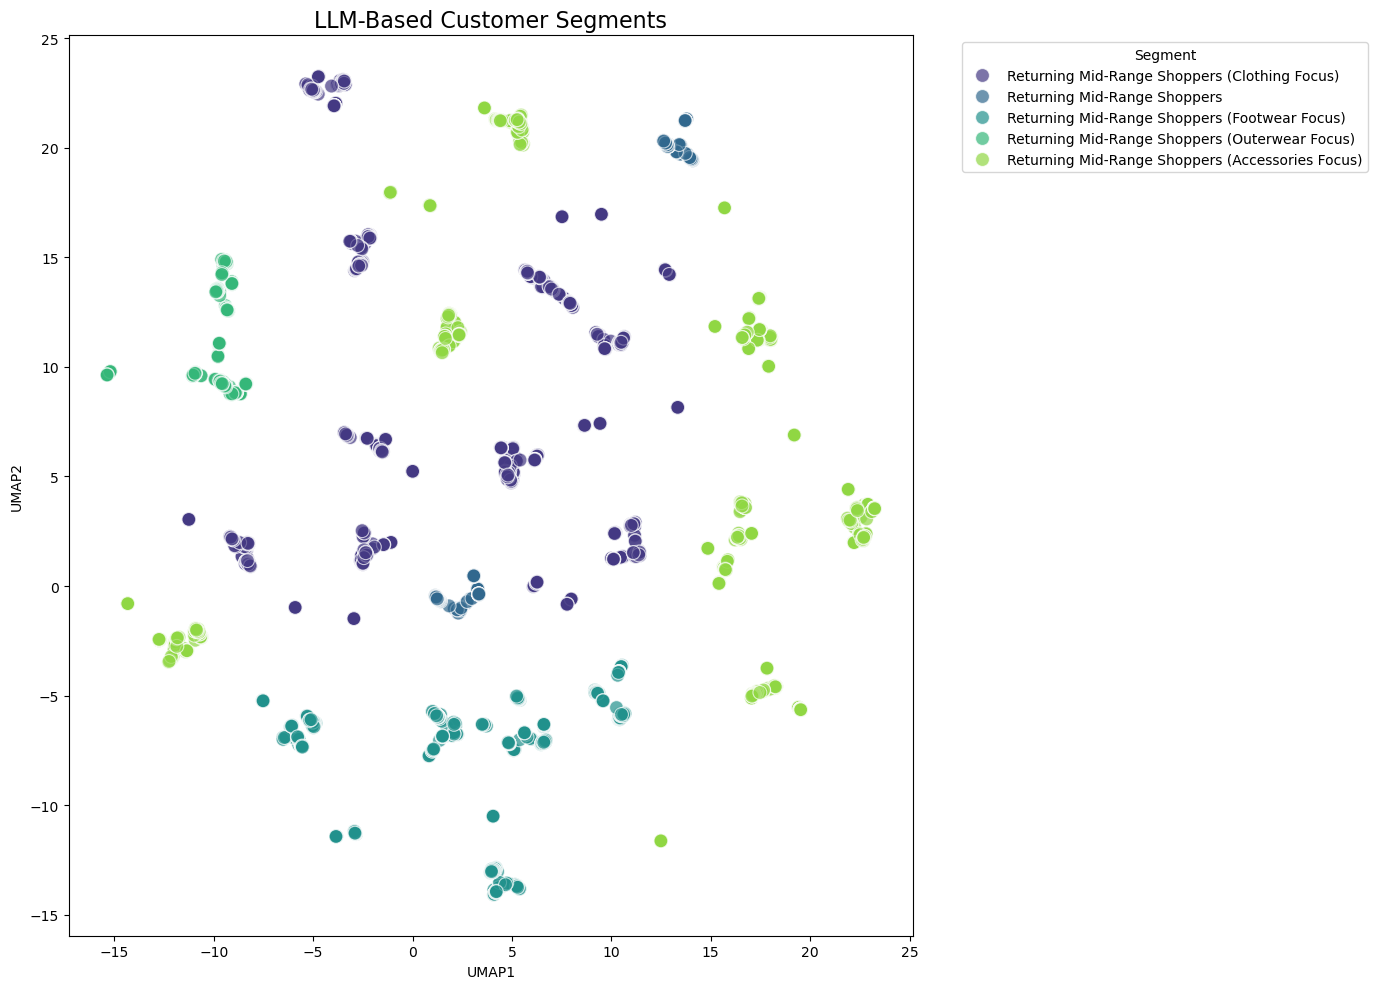

In [136]:
# Map cluster numbers to names
df['Segment'] = df['Cluster'].map(segment_names)

# Visualize the clusters
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df,
    x='UMAP1',
    y='UMAP2',
    hue='Segment',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('LLM-Based Customer Segments', fontsize=16)
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [138]:
# Generate segment insights and marketing recommendations
print("\n--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS ---")

for cluster, segment_name in segment_names.items():
    segment_data = df[df['Cluster'] == cluster]
    count = len(segment_data)
    pct = count / len(df) * 100
    
    print(f"\n=== {segment_name} ===")
    print(f"Size: {count} customers ({pct:.1f}% of total)")
    
    # Calculate key metrics
    avg_purchase = segment_data['Purchase Amount (USD)'].mean()
    freq_counts = segment_data['Frequency of Purchases'].value_counts().nlargest(2)
    avg_previous = segment_data['Previous Purchases'].mean()
    avg_rating = segment_data['Review Rating'].mean()
    discount_usage = (segment_data['Discount Applied'] == 'Yes').mean() * 100
    promo_usage = (segment_data['Promo Code Used'] == 'Yes').mean() * 100
    subscription_rate = (segment_data['Subscription Status'] == 'Yes').mean() * 100
    
    # Top categories and products
    top_categories = segment_data['Category'].value_counts().nlargest(2)
    top_items = segment_data['Item Purchased'].value_counts().nlargest(3)
    top_seasons = segment_data['Season'].value_counts().nlargest(2)
    top_colors = segment_data['Color'].value_counts().nlargest(3)
    
    # Print segment profile
    print("\nKEY CHARACTERISTICS:")
    print(f"• Average purchase: ${avg_purchase:.2f}")
    print(f"• Purchase frequency: {', '.join([f'{freq} ({count})' for freq, count in freq_counts.items()])}")
    print(f"• Previous purchases: {avg_previous:.1f}")
    print(f"• Average rating: {avg_rating:.1f}/5")
    print(f"• Discount usage: {discount_usage:.1f}%")
    print(f"• Promo code usage: {promo_usage:.1f}%")
    print(f"• Subscription rate: {subscription_rate:.1f}%")
    
    print("\nPRODUCT PREFERENCES:")
    print("• Top categories:")
    for cat, count in top_categories.items():
        print(f"  - {cat}: {count} purchases ({count/len(segment_data)*100:.1f}% of segment)")
    
    print("• Top items:")
    for item, count in top_items.items():
        print(f"  - {item}: {count} purchases")
    
    print("• Top seasons:")
    for season, count in top_seasons.items():
        print(f"  - {season}: {count} purchases")
    
    print("• Top colors:")
    for color, count in top_colors.items():
        print(f"  - {color}: {count} purchases")
    


--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS ---

=== Returning Mid-Range Shoppers ===
Size: 288 customers (7.4% of total)

KEY CHARACTERISTICS:
• Average purchase: $59.16
• Purchase frequency: Weekly (53), Bi-Weekly (47)
• Previous purchases: 24.6
• Average rating: 3.8/5
• Discount usage: 46.9%
• Promo code usage: 46.9%
• Subscription rate: 30.9%

PRODUCT PREFERENCES:
• Top categories:
  - Clothing: 152 purchases (52.8% of segment)
  - Accessories: 136 purchases (47.2% of segment)
• Top items:
  - Sweater: 152 purchases
  - Backpack: 136 purchases
• Top seasons:
  - Spring: 87 purchases
  - Fall: 72 purchases
• Top colors:
  - Olive: 18 purchases
  - Orange: 17 purchases
  - Maroon: 16 purchases

=== Returning Mid-Range Shoppers (Footwear Focus) ===
Size: 758 customers (19.4% of total)

KEY CHARACTERISTICS:
• Average purchase: $59.82
• Purchase frequency: Annually (116), Every 3 Months (116)
• Previous purchases: 25.2
• Average rating: 3.8/5
• Discount usage: 41.0%
• Promo code u

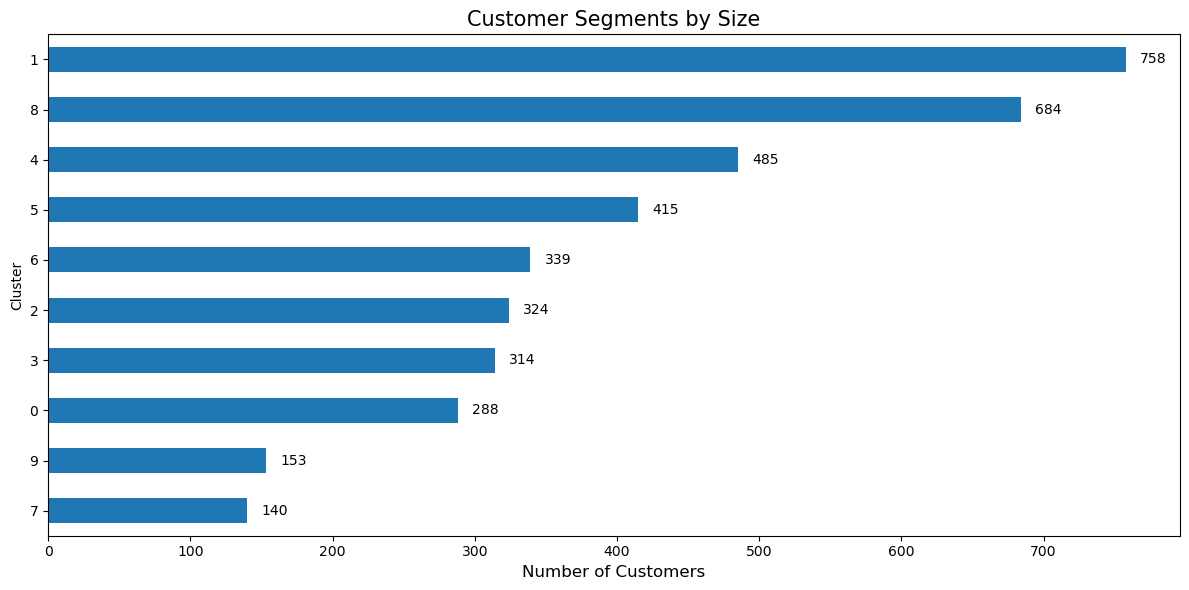

In [144]:
# Visualize segments bar chart showing segment sizes
plt.figure(figsize=(12, 6))
ax = segment_stats['Count'].sort_values().plot(kind='barh')
plt.title('Customer Segments by Size', fontsize=15)
plt.xlabel('Number of Customers', fontsize=12)
for i, v in enumerate(segment_stats['Count'].sort_values()):
    ax.text(v + 10, i, str(v), va='center')
plt.tight_layout()
plt.show()

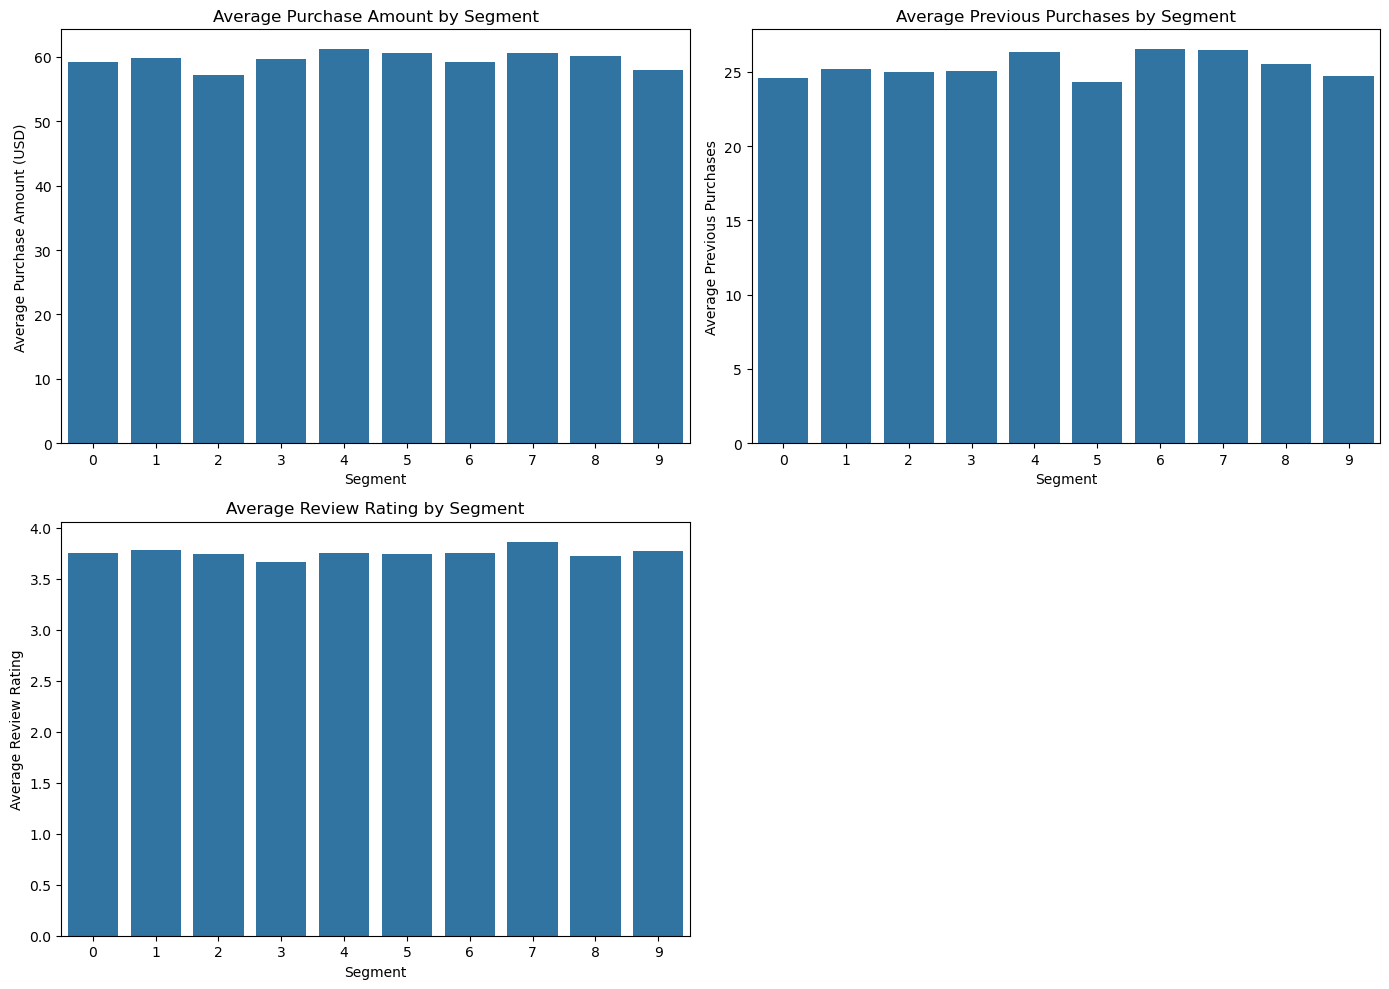

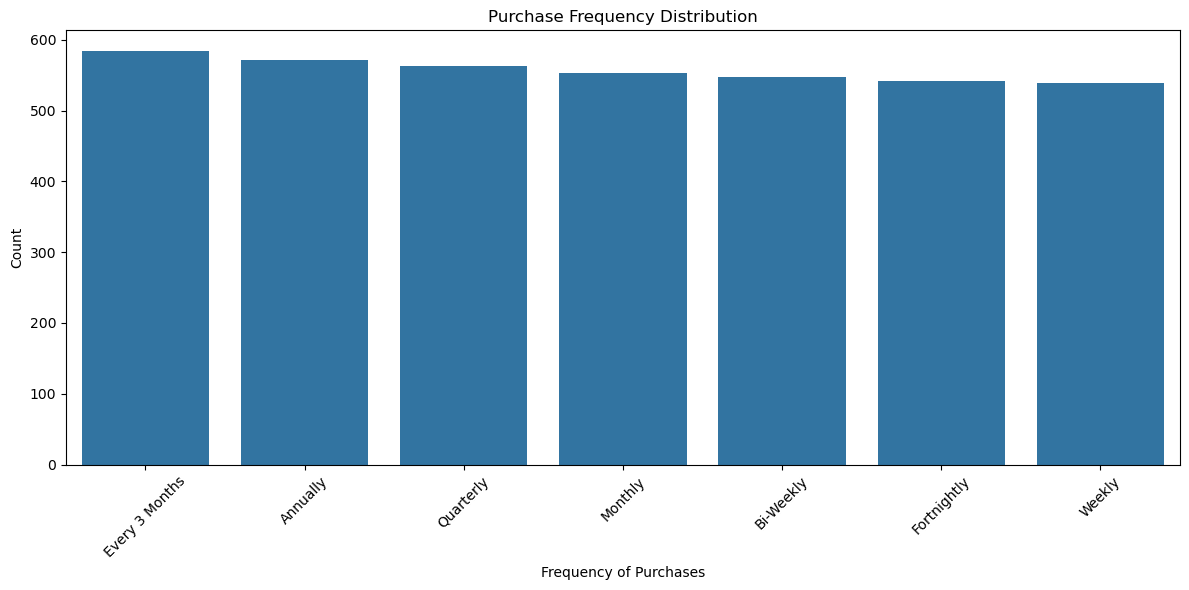

In [149]:
# Create a visualization of key metrics by segment
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.barplot(data=df, x='Cluster', y='Purchase Amount (USD)', ci=None)
plt.title('Average Purchase Amount by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Purchase Amount (USD)')
plt.subplot(2, 2, 2)
sns.barplot(data=df, x='Cluster', y='Previous Purchases', ci=None)
plt.title('Average Previous Purchases by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Previous Purchases')
plt.subplot(2, 2, 3)
sns.barplot(data=df, x='Cluster', y='Review Rating', ci=None)
plt.title('Average Review Rating by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Review Rating')
plt.tight_layout()
plt.show()

# Frequency value plot
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Frequency of Purchases', order=df['Frequency of Purchases'].value_counts().index)
plt.title('Purchase Frequency Distribution')
plt.xlabel('Frequency of Purchases')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [151]:
# Segment Profiles
print("\n--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS ---")

segment_descriptions = {
    "Loyal Customers": "Customers with high purchase history who maintain subscriptions.",
    "High-Value Shoppers": "Customers who spend more than average and have established purchase history.",
    "Discount Seekers": "Price-conscious customers who consistently use discounts and promotions.",
    "New Customers": "Recent additions to your customer base with limited purchase history.",
    "Frequent Shoppers": "Customers who shop regularly throughout the year.",
    "Category Enthusiasts": "Customers who focus their purchases in a specific product category.",
    "Regular Customers": "Standard customers who don't fall into specialized segments."
}

marketing_recommendations = {
    "Loyal Customers": [
        "Create a tiered VIP program with exclusive benefits",
        "Offer early access to new products and collections",
        "Implement a referral program with meaningful rewards",
        "Provide personalized shopping experiences and recommendations",
        "Seek their feedback on new products and services"
    ],
    "High-Value Shoppers": [
        "Develop specialized high-end product collections",
        "Create bundle offers of complementary premium products",
        "Implement a white-glove customer service approach",
        "Offer exclusive events and experiences",
        "Focus on storytelling and quality in marketing messages"
    ],
    "Discount Seekers": [
        "Create a strategic promotion calendar to maximize impact",
        "Implement limited-time offers to create urgency",
        "Use tiered promotions (spend more, save more)",
        "Test various promotion types to find optimal conversion structure",
        "Consider a points program that rewards multiple purchases"
    ],
    "New Customers": [
        "Create an onboarding email series to build relationship",
        "Offer 'second purchase' incentives with clear timeframes",
        "Provide educational content about product benefits and usage",
        "Showcase social proof with reviews and testimonials",
        "Implement early re-engagement campaigns if no repeat purchase"
    ],
    "Frequent Shoppers": [
        "Create a frequency-based rewards program",
        "Develop consistent touchpoints between purchases",
        "Implement surprise-and-delight moments to increase loyalty",
        "Focus on cross-selling complementary products",
        "Consider subscription options for regularly purchased items"
    ],
    "Category Enthusiasts": [
        "Create specialized content focused on their category of interest",
        "Offer category-specific loyalty benefits",
        "Introduce new products within their preferred category first",
        "Develop category expert positioning in marketing",
        "Test strategic cross-category promotions to expand their purchases"
    ],
    "Regular Customers": [
        "Implement a basic loyalty program to encourage retention",
        "Create seasonal re-engagement campaigns",
        "Test various product recommendations to find new interests",
        "Develop mid-tier promotional offers",
        "Focus on upgrading their customer experience"
    ]
}



--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS ---


In [154]:
product_strategies = {
    "Loyal Customers": "Focus on premium products and new releases.",
    "High-Value Shoppers": "Showcase luxury items, exclusive editions, and premium collections.",
    "Discount Seekers": "Create value bundles, entry-price-point options, and promotional specials.",
    "New Customers": "Highlight bestsellers, starter sets, and easy-to-understand product lines.",
    "Frequent Shoppers": "Offer variety, seasonal collections, and replenishment reminders.",
    "Category Enthusiasts": "Provide depth in their preferred category with specialized options.",
    "Regular Customers": "Promote mid-range products with good value-to-quality ratio."
}

# Add a function to handle unknown segments
def get_generic_description(segment_name):
    if "Loyal" in segment_name:
        return segment_descriptions["Loyal Customers"]
    elif "High-Value" in segment_name:
        return segment_descriptions["High-Value Shoppers"]
    elif "Discount" in segment_name:
        return segment_descriptions["Discount Seekers"]
    elif "New" in segment_name:
        return segment_descriptions["New Customers"]
    elif "Frequent" in segment_name:
        return segment_descriptions["Frequent Shoppers"]
    elif "Category" in segment_name or "focus" in segment_name:
        return segment_descriptions["Category Enthusiasts"]
    elif "Returning" in segment_name or "Mid-Range" in segment_name:
        return "Customers who have made repeat purchases with moderate spending levels."
    else:
        return "Customers with specific shopping patterns and preferences."

def get_generic_recommendations(segment_name):
    if "Loyal" in segment_name:
        return marketing_recommendations["Loyal Customers"]
    elif "High-Value" in segment_name:
        return marketing_recommendations["High-Value Shoppers"]
    elif "Discount" in segment_name:
        return marketing_recommendations["Discount Seekers"]
    elif "New" in segment_name:
        return marketing_recommendations["New Customers"]
    elif "Frequent" in segment_name:
        return marketing_recommendations["Frequent Shoppers"]
    elif "Category" in segment_name or "focus" in segment_name:
        return marketing_recommendations["Category Enthusiasts"]
    elif "Returning" in segment_name or "Mid-Range" in segment_name:
        return [
            "Develop targeted mid-tier offers for repeat purchases",
            "Create cross-selling opportunities within their price range",
            "Implement occasional upgrade promotions for higher-value items",
            "Focus on consistent quality and reliability in messaging",
            "Provide category-specific recommendations based on past purchases"
        ]
    else:
        return [
            "Test various marketing approaches to determine best engagement",
            "Develop segment-specific messaging based on behavior patterns",
            "Create relevant product recommendations based on purchase history",
            "Implement targeted retention strategies",
            "Analyze segment for further specialization opportunities"
        ]

In [156]:
def get_generic_product_strategy(segment_name):
    if "Loyal" in segment_name:
        return product_strategies["Loyal Customers"]
    elif "High-Value" in segment_name:
        return product_strategies["High-Value Shoppers"]
    elif "Discount" in segment_name:
        return product_strategies["Discount Seekers"]
    elif "New" in segment_name:
        return product_strategies["New Customers"]
    elif "Frequent" in segment_name:
        return product_strategies["Frequent Shoppers"]
    elif "Category" in segment_name or "focus" in segment_name:
        category = segment_name.split("(")[1].split(")")[0].replace("focus", "").strip() if "(" in segment_name else "preferred"
        return f"Provide depth in {category} category with specialized options."
    elif "Returning" in segment_name or "Mid-Range" in segment_name:
        return "Promote mid-range products with good quality and consistent value."
    else:
        return "Analyze purchase patterns to identify optimal product recommendations."

for segment in df['Primary_Segment'].unique():
    segment_data = df[df['Primary_Segment'] == segment]
    count = len(segment_data)
    pct = count / len(df) * 100
    
    print(f"\n=== {segment} ===")
    print(f"Size: {count} customers ({pct:.1f}% of total)")
    
    # Get description for known or unknown segments
    if segment in segment_descriptions:
        description = segment_descriptions[segment]
    else:
        description = get_generic_description(segment)
    
    print(f"Description: {description}")


=== Returning Mid-Range Shoppers (Clothing Focus) ===
Size: 1413 customers (36.2% of total)
Description: Customers who have made repeat purchases with moderate spending levels.

=== Returning Mid-Range Shoppers ===
Size: 288 customers (7.4% of total)
Description: Customers who have made repeat purchases with moderate spending levels.

=== Returning Mid-Range Shoppers (Footwear Focus) ===
Size: 758 customers (19.4% of total)
Description: Customers who have made repeat purchases with moderate spending levels.

=== Returning Mid-Range Shoppers (Outerwear Focus) ===
Size: 324 customers (8.3% of total)
Description: Customers who have made repeat purchases with moderate spending levels.

=== Returning Mid-Range Shoppers (Accessories Focus) ===
Size: 1117 customers (28.6% of total)
Description: Customers who have made repeat purchases with moderate spending levels.


In [157]:
# Calculate key metrics
avg_purchase = segment_data['Purchase Amount (USD)'].mean()
freq_counts = segment_data['Frequency of Purchases'].value_counts().nlargest(2)
avg_previous = segment_data['Previous Purchases'].mean()
avg_rating = segment_data['Review Rating'].mean()
discount_usage = (segment_data['Discount Applied'] == 'Yes').mean() * 100
promo_usage = (segment_data['Promo Code Used'] == 'Yes').mean() * 100
subscription_rate = (segment_data['Subscription Status'] == 'Yes').mean() * 100

In [158]:
# Top categories and products
top_categories = segment_data['Category'].value_counts().nlargest(2)
top_items = segment_data['Item Purchased'].value_counts().nlargest(3)
top_colors = segment_data['Color'].value_counts().nlargest(2)

In [159]:
# Print segment profile
print("\nKEY CHARACTERISTICS:")
print(f"• Average purchase: ${avg_purchase:.2f}")
print(f"• Purchase frequency: {avg_frequency:.1f} times per year")
print(f"• Previous purchases: {avg_previous:.1f}")
print(f"• Average rating: {avg_rating:.1f}/5")
print(f"• Discount usage: {discount_usage:.1f}%")
print(f"• Promo code usage: {promo_usage:.1f}%")
print(f"• Subscription rate: {subscription_rate:.1f}%")
    
print("\nPRODUCT PREFERENCES:")
print("• Top categories:")
for cat, count in top_categories.items():
    print(f"  - {cat}: {count} purchases ({count/len(segment_data)*100:.1f}% of segment)")
    
print("• Top products:")
for item, count in top_items.items():
    print(f"  - {item}: {count} purchases")
    
print("• Top colors:")
for color, count in top_colors.items():
    print(f"  - {color}: {count} purchases")
    
# Get product strategy for known or unknown segments
if segment in product_strategies:
    product_strategy = product_strategies[segment]
else:
    product_strategy = get_generic_product_strategy(segment)
    
print("\nPRODUCT STRATEGY:")
print(product_strategy)


KEY CHARACTERISTICS:
• Average purchase: $60.09
• Purchase frequency: 17.1 times per year
• Previous purchases: 26.2
• Average rating: 3.8/5
• Discount usage: 42.5%
• Promo code usage: 42.5%
• Subscription rate: 26.1%

PRODUCT PREFERENCES:
• Top categories:
  - Accessories: 950 purchases (85.0% of segment)
  - Clothing: 167 purchases (15.0% of segment)
• Top products:
  - Jewelry: 171 purchases
  - Sunglasses: 161 purchases
  - Belt: 161 purchases
• Top colors:
  - Teal: 58 purchases
  - Charcoal: 57 purchases

PRODUCT STRATEGY:
Promote mid-range products with good quality and consistent value.


In [160]:
print("\nMARKETING RECOMMENDATIONS:")
# Get recommendations for known or unknown segments
if segment in marketing_recommendations:
    recommendations = marketing_recommendations[segment]
else:
    recommendations = get_generic_recommendations(segment)
    
for i, recommendation in enumerate(recommendations, 1):
    print(f"{i}. {recommendation}")


MARKETING RECOMMENDATIONS:
1. Develop targeted mid-tier offers for repeat purchases
2. Create cross-selling opportunities within their price range
3. Implement occasional upgrade promotions for higher-value items
4. Focus on consistent quality and reliability in messaging
5. Provide category-specific recommendations based on past purchases
